# Descrição do Projeto

A empresa Sweet Lift Taxi coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora. 	
Construa um modelo para tal predição.

A métrica REQM no conjunto de teste não deve ser superior a 48.

## Descrição dos dados

Os dados são armazenados no arquivo `taxi.csv`. O número de pedidos está na coluna `num_orders`.

## Preparação 

### Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_validate
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

sns.set_theme(style="whitegrid")

### Lendo arquivo csv determinando as datas como index e transformando em datetime

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data = data.sort_index()

In [3]:
data.index.is_monotonic_increasing

True

### Conhecendo o dataframe

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Vemos que as colunas correspondem as datas e o formato está como Datetime

In [5]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Aqui vemos que o intervalo do timestamp está em minutos (a cada 10 minutos), a coluna num_oders mostra o número de pedidos no intervalo de tempo.

In [6]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Há 26496 observações no dataframe, a média é de 14,07 pedidos a cada 10 minutos, o desvio padrão de 9.21 mostra um grau relativamente alto de variabilidade no número de pedidos. O valor minimo é 0, ou seja, tem horários em que não há pedidos. Os percentis 25%, 50% e 75% mostra o número de pedidos que ficam abaixo de cada percentil. O valor máximo de pedidos foi de 119.

### Valores ausentes

In [7]:
pd.crosstab(index=data.index.month, columns=data.index.hour)

col_0,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
row_0,,,,,,,,,,,,,,,,,,,,,
3,186,186,186,186,186,186,186,186,186,186,...,186,186,186,186,186,186,186,186,186,186
4,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
5,186,186,186,186,186,186,186,186,186,186,...,186,186,186,186,186,186,186,186,186,186
6,180,180,180,180,180,180,180,180,180,180,...,180,180,180,180,180,180,180,180,180,180
7,186,186,186,186,186,186,186,186,186,186,...,186,186,186,186,186,186,186,186,186,186
8,186,186,186,186,186,186,186,186,186,186,...,186,186,186,186,186,186,186,186,186,186


Como nas séries temporais a função isna() não reconhece datas faltantes e, portanto, não encontra missing values é importante ver o número de observações. Nesse caso o tabela mostra que cada mês tem o mesmo número de observações por hora. Então não há valores ausentes no dataframe.

## Análise

### Agrupando os dados em intervalos de 1 hora e analisando resultados

In [8]:
data_hour = data.resample('1H').sum()

In [9]:
data_hour.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


Vemos que o intervalo de tempo passou de 10 minutos para intervalos de 1 hora.

In [10]:
data_hour.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Há 4416 observações no dataframe, a média é de 84,42 pedidos a cada 1 hora, o desvio padrão de 45,02 mostra que há bastante variabilidade no número de pedidos. O valor minimo é 0, ou seja, tem horários em que não há pedidos. Os percentis 25%, 50% e 75% mostra o número de pedidos que ficam abaixo de cada percentil. O valor máximo de pedidos foi de 462.

### Plotando gráfico com a média móvel e janela de 24 horas

In [11]:
data_hour['rolling_mean'] = data_hour.rolling(window=24).mean()

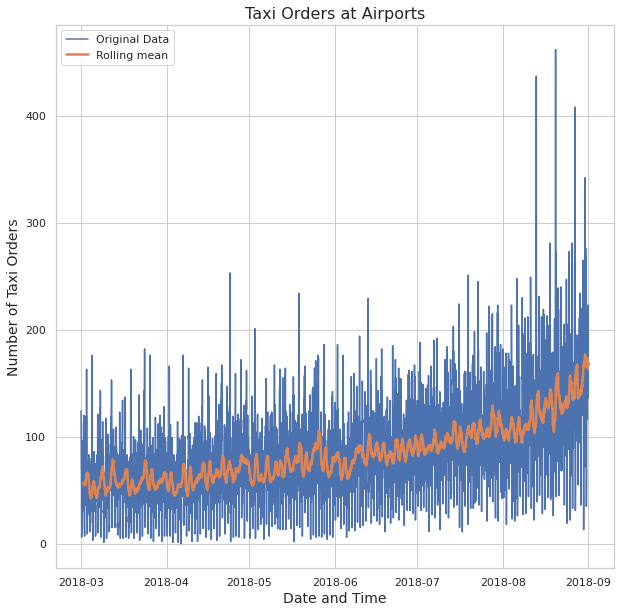

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(x=data_hour.index, y='num_orders', label='Original Data', data=data_hour)
sns.lineplot(x=data_hour.index, y='rolling_mean', label='Rolling mean', palette="tab10", linewidth=2.5, data=data_hour)
ax.set_xlabel('Date and Time', fontsize=14)
ax.set_ylabel('Number of Taxi Orders', fontsize=14)
ax.set_title('Taxi Orders at Airports', fontsize=16)
ax.legend()
plt.show()

O gráfico com a média móvel mostra uma pequena tendência de crescimento ao longo dos meses do ano. Os picos e vales, melhor visualizado na linha da média móvel, sugere que a quantidade de pedidos de taxi muda durante as 24 horas. Também é possível ver a variabilidade dos dados em relação a média móvel.

### Procurando por outliers

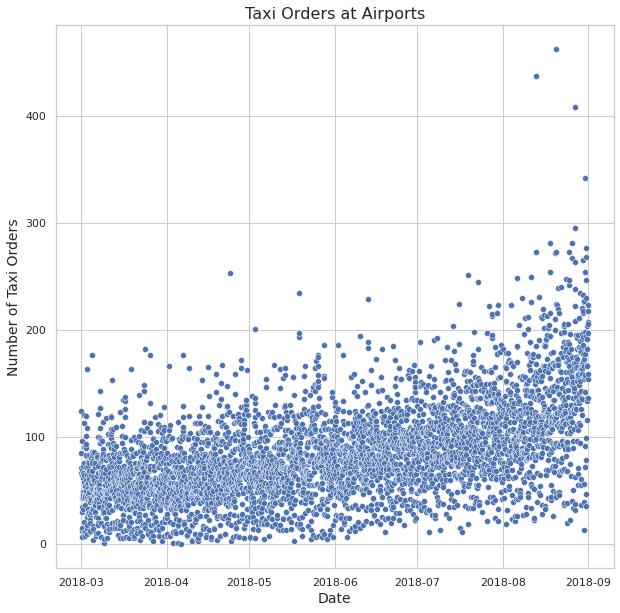

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x = data_hour.index, 
            y = 'num_orders', 
                ax = ax, data=data_hour)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Number of Taxi Orders', fontsize=14)
ax.set_title('Taxi Orders at Airports', fontsize=16)

plt.show()

A quantidade de outiliers pode estar influenciando nos picos mais altos do primeiro plot com a média móvel. Como os dados são extremos, mas possíveis de acontecer na realidade opto por não tratar esses outliers.

### Decomposição dos dados

In [14]:
data_hour.drop('rolling_mean', axis=1, inplace=True)

É necessário remover a coluna de média móvel, pois como há missing values nessa coluna levará ao ValueError (This function does not handle missing values) na decomposição da série temporal.

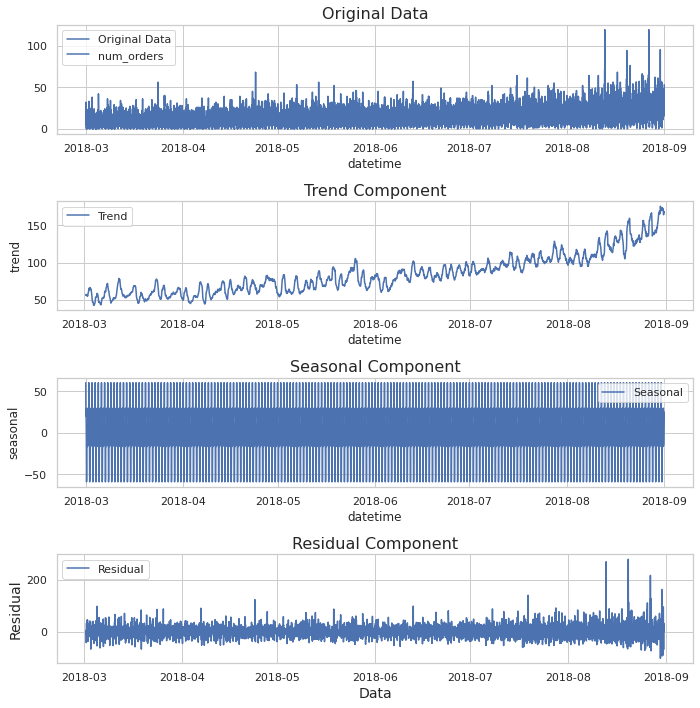

In [15]:
decomposition = seasonal_decompose(data_hour)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))
sns.lineplot(data=data, ax=ax[0], label='Original Data')
ax[0].set_title('Original Data', fontsize=16)
sns.lineplot(data=decomposition.trend, ax=ax[1], label='Trend')
ax[1].set_title('Trend Component', fontsize=16)
sns.lineplot(data=decomposition.seasonal, ax=ax[2], label='Seasonal')
ax[2].set_title('Seasonal Component', fontsize=16)
sns.lineplot(data=decomposition.resid, ax=ax[3], label='Residual')
ax[3].set_title('Residual Component', fontsize=16)
ax[3].set_xlabel('Data', fontsize=14)
ax[3].set_ylabel('Residual', fontsize=14)
plt.tight_layout()
plt.show()

A decomposição sugere que há uma tendência ascendente nos dados, o padrão sazonal é repetitivo e influencia os dados ao longo das 24 horas. Existe alguma variabilidade nos dados mostrado pelo componente residual.

Plotando gráfico para melhor visualizar a sazonalidade

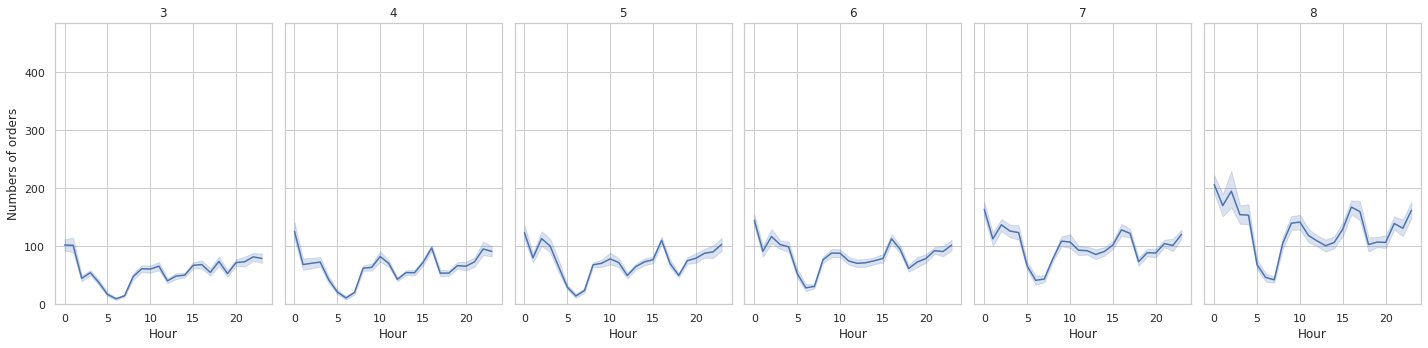

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(20, 5), sharey=True)

limits = [data.resample('H').sum()['num_orders'].min() * 0.95, data.resample('H').sum()['num_orders'].max() * 1.05]

for i, (month, dfg) in enumerate(data.groupby(data.index.month)):
    dfg = dfg.resample('H').sum()
    sns.lineplot(x=dfg.index.hour, y=dfg['num_orders'], ax=axs[i])
    axs[i].set_title(month, fontsize=12)
    axs[i].set_ylim(limits)
    axs[i].set_ylabel('Numbers of orders', fontsize=12)
    axs[i].set_xlabel('Hour', fontsize=12)
    
plt.tight_layout()


O padrão de sazonalidade está evidente, os número de pedidos aumentam nos horários de pico e diminuem nos horários fora de pico. Há uma pequena variação do padrão sazonal ao longo dos meses. No primeiro mês e no último é possível ver que houve aumento no número de pedidos durante o horário de pico da manhã, enquanto nos meses intermediários esse aumento não é tão expressivo.

### Estacionariedade

In [17]:
#Calculando o teste estatístico de ad fuller 
adf = adfuller(data_hour['num_orders'])[1]
print(f'p value:{adf.round(4)}', ' Series is Stationary' if adf <0.05 else ', Series is Non-Stationary')

p value:0.0289  Series is Stationary


Pelo teste estatístico e o gráfico de decomposição da série, é possível observar que a amplitude da sazonalidade é relativamente constante ao longo do tempo, indicando que se trata de uma série temporal aditiva, portanto, estacionária. 

Série temporal estacionária quer dizer que a média, variância e autocorrelação, não mudam com o tempo. Sendo assim, não é necessário transformar a série. 

Saber se uma série temporal é estacionária ou não é importante porque ajuda a detctar necessidades de transformação nos, tornando a análise e modelagem precisas e confiáveis.

## Histograma e simetria dos dados

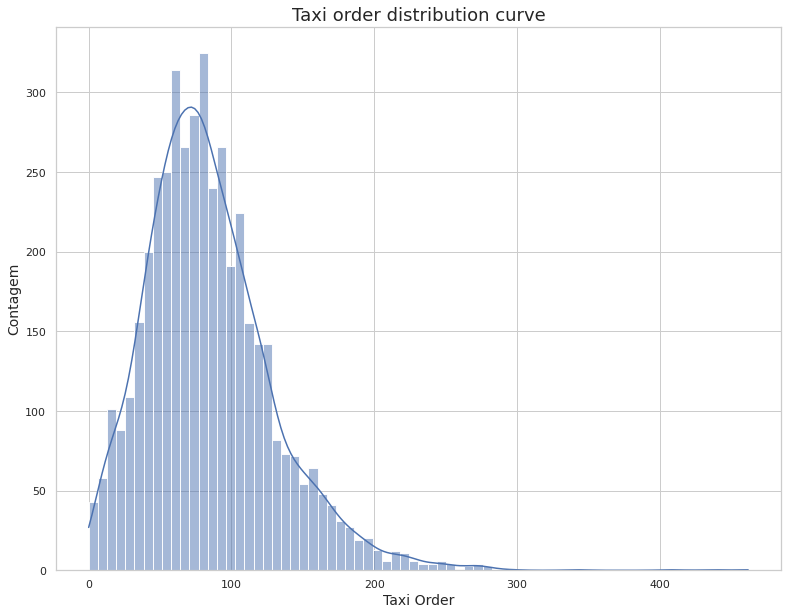

In [18]:
fig, axs = plt.subplots(figsize=(13, 10));
sns.histplot(data_hour.num_orders, kde=True);
plt.title('Taxi order distribution curve', fontsize=18);
plt.ylabel('Contagem', fontsize=14);
plt.xlabel('Taxi Order', fontsize=14);
plt.show()

In [19]:
asymmetry = data_hour.skew()
print(asymmetry)
if (asymmetry > 0).all():
    print('A distribuição é assimétrica positiva.')
elif (asymmetry < 0).all():
    print('A distribuição é assimétrica negativa.')
else:
    print('A distribuição é simétrica.')

num_orders    1.188956
dtype: float64
A distribuição é assimétrica positiva.


A série não possui distribuição normal e sim assimetria à direita ou assimetria positiva quando existe uma maior concentração de valores na zona de valores mais reduzidos da amostra. Sendo assim, os dados precisão ser transformados para se tornarem mais proximado da distribuição simétrica.

### Determinando feature engineer e lag

In [20]:
def make_features(data, max_lag, rolling_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(window=rolling_size).mean()
    )
    data['rolling_min'] = data['num_orders'].rolling(window=rolling_size).min()
    data['rolling_max'] = data['num_orders'].rolling(window=rolling_size).max()

### Auto-correlação

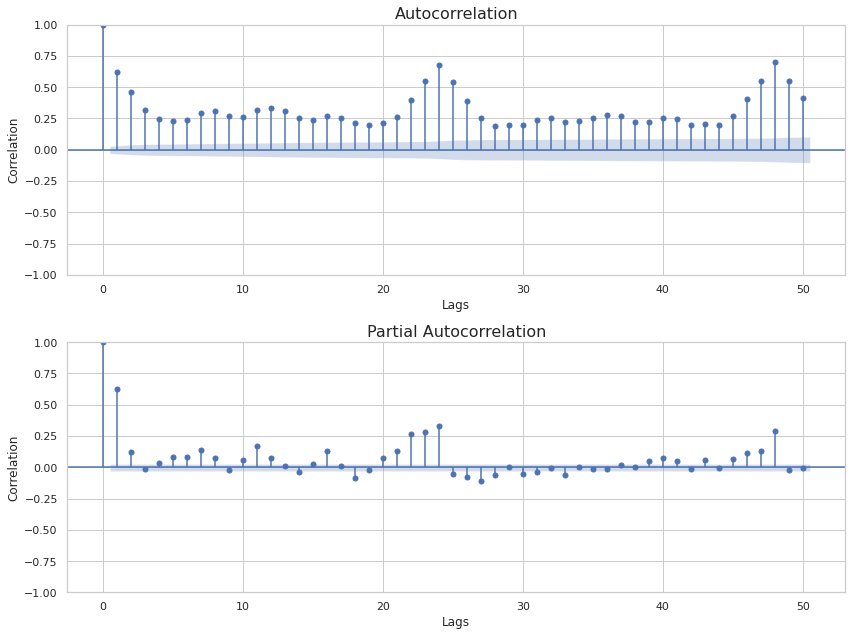

In [21]:
fig, axs = plt.subplots(nrows=2, figsize=(12, 9))
plot_acf(data_hour['num_orders'], lags=50, ax=axs[0])
plot_pacf(data_hour['num_orders'], lags=50, method='ywm', ax=axs[1])
axs[0].set_xlabel('Lags')
axs[0].set_ylabel('Correlation')
axs[0].set_title('Autocorrelation', fontsize=16)
axs[1].set_xlabel('Lags')
axs[1].set_ylabel('Correlation')
axs[1].set_title('Partial Autocorrelation', fontsize=16)
plt.tight_layout()
plt.show()

Auto-correlação mostra a correlação da série temporal com seus próprios valores passados, ou seja, a intimamente relação do valor atual e seus valores passados. Já a Auto-Correlação Parcial mostra a correlação entre duas variáveis e controla o efeito de outras variáveis, possibilitando identificar a relação direta entre duas variáveis, após retirar a influência de outras variáveis na análise.

Observando os dois gráficos vemos que a última correlação estatisticamente significativa ocorre no lag 2, depois as correlações tendem a diminuir. Mostrando que a série parece ser independente dos seus valores passados e pode estar mais afetada pela sazonalidade (aumento dos pedidos em horas de pico)

Então é possível utilizar o valor de lag 2 na feture engineer, pois é um dos possíveis preditores para o modelo de série temporal. Nos valores de lag 1 e 2 encontramos os valores significativos de auto-correlação.

In [22]:
make_features(data_hour, 2, 24)

In [23]:
data_hour.head(10)

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,rolling_mean,rolling_min,rolling_max
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,NaN,NaN,NaN
2018-03-01 05:00:00,6,2018,3,1,3,5,43.0,66.0,NaN,NaN,NaN
2018-03-01 06:00:00,12,2018,3,1,3,6,6.0,43.0,NaN,NaN,NaN
2018-03-01 07:00:00,15,2018,3,1,3,7,12.0,6.0,NaN,NaN,NaN
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,NaN,NaN,NaN


Nessa etapa foram adicionados dados complementares a série temporal:

* A feature "year", "month" e "day" foram adicionadas para capturar o efeito sazonal anual, mensal, diário nos dados de pedidos, respectivamente. A feature "dayofweek" foi adicionada para capturar o efeito do dia da semana nos dados. E, por fim, a feature "hour" foi adicionada para capturar a variação de horários nos dados.


* Os valores de lags foram adicionadas para capturar o efeito da dependência temporal nos dados de pedidos. As features "lag_1" e "lag_2" correspondem às observações de pedidos dos dois dias anteriores(escolhidos com base na auto-correlação). 



* A feature "rolling_mean" corresponde à média móvel de 24 horas dos dados de pedidos, enquanto "rolling_min" e "rolling_max" correspondem ao valor mínimo e máximo dos dados de pedidos no período de 24 horas.

## Treinamento

### Excluindo os valores nulos 

In [24]:
data_hour = data_hour.dropna()
## Instruções do projeto

1. Faça download dos dados e faça uma nova amostragem em uma hora.
2. Analise os dados
3. Treine diferentes modelos com diferentes hiperparâmetros. A amostra de teste deve ser 10% do conjunto de dados inicial.
4. Teste os dados usando a amostra de teste e forneça uma conclusão.

Isso é feito para que seja possível testar o modelo escolhido, uma vez que modelos de regressão não aceitam NaN values.

### Separando o dataframe

In [25]:
features = data_hour.drop(columns=['num_orders'])
target = data_hour['num_orders']

In [26]:
#Separando o dataframe em treino e teste, com tamanho do teste de 10%
train_data, test_data, train_target, test_target = train_test_split(features, target, test_size=0.1)


### Normalização do conjunto

In [27]:
# Procurando por valores igauis a zero ou negativos no conjunto de treinamento e teste
zero_cols_train = (train_data <= 0).any()
zero_cols_test = (test_data <= 0).any()

# Adicionando pequeno valor constante a esses valores
train_data.loc[:, zero_cols_train] += 1e-8
test_data.loc[:, zero_cols_test] += 1e-8

# Aplicando transformação logarítmica natural nos dados
train_data_log = np.log(train_data)
test_data_log = np.log(test_data)

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


Como os dados da serie temporal são assimetricos é importante deixar os dados o mais proximo possível da distribuição normal. Com a transformação logarítimica natural é possível atenuar o impacto de valores extremos nos dados. Os valores iguais a zero ou negativos são números indefinidos e ao adicinar a constante esses valores passam a ser positivos permitindo que o logarítmo seja calculado. 

### Treinamento e tuning de hiperparametros

In [28]:
def hyperparameter_tuning(model_name, X, y):
    
    if model_name == 'LinearRegression':
        model = LinearRegression()
        param_grid = {'normalize': [True, False]}
        
    elif model_name == 'DecisionTreeRegressor':
        model = DecisionTreeRegressor()
        param_grid = {'max_depth': [3, 5],
                      'min_samples_split': [2, 5]}
        
    elif model_name == 'RandomForestRegressor':
        model = RandomForestRegressor()
        param_grid = {'n_estimators': [100, 200],
                      'max_depth': [5, 10]}
        
    else:
        raise ValueError('Invalid model name')
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X)
    reqm = np.sqrt(mean_squared_error(y, y_pred))
   
    return print(best_params, reqm)


Hiperparametros escolhidos:

Para evitar longo tempo de execução do treinamento e teste optei por fazer tunning de poucos hiperparametros.

No modelo de **regressão linear** o hiperparametro <em>'normalize'</em> determina se os dados de entrada devem ser normalizados ou não. 

Na **regressão de árvore de decisão** o hiperparametro <em>'max_depth'</em> define a profundidade máxima da árvore de decisão, limitando o número de níveis de nós na árvore e <em>'min_samples_split'</em> define o número mínimo de amostras necessárias para dividir um nó interno. Esses hiperparâmetros controlam a complexidade da árvore de decisão e ajudam a evitar o overfitting. 

Na **regressão de floresta aleatória** o hiperparametro <em>'n_estimators'</em> define o número de árvores de decisão a serem usadas na floresta aleatória e <em>'max_depth'</em> define a profundidade máxima de cada árvore de decisão. Ambos os hiperparâmetros controlam o tamanho e a complexidade da floresta aleatória, evitando overffiting

In [29]:
model_name = 'LinearRegression'
best_model = hyperparameter_tuning(model_name, features, target)


{'normalize': False} 33.253191032234


In [30]:
model_name = 'DecisionTreeRegressor'
best_model = hyperparameter_tuning(model_name, features, target)

{'max_depth': 5, 'min_samples_split': 2} 26.899236370400292


In [31]:
model_name = 'RandomForestRegressor'
hyperparameter_tuning(model_name, features, target)

{'max_depth': 10, 'n_estimators': 200} 16.566136490253736


O modelo com melhor métrica(16.58) foi a Regressão de Floresta Aleatória com os parâmetros de profundidade máxima de 10 e número de estimadores igual a 200.

## Testando

In [32]:
model = RandomForestRegressor(max_depth=10, n_estimators=200)
model.fit(train_data_log, train_target)
prediction_train = model.predict(train_data_log)
prediction_test = model.predict(test_data_log)

reqm_train = np.sqrt(mean_squared_error(train_target, prediction_train))
reqm_test = np.sqrt(mean_squared_error(test_target, prediction_test))

print(f"REQM Treino: {np.around(reqm_train)}")
print(f"REQM Teste: {np.around(reqm_test)}")

REQM Treino: 16.0
REQM Teste: 22.0


In [33]:
model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=2)
model.fit(train_data_log, train_target)
prediction_train = model.predict(train_data_log)
prediction_test = model.predict(test_data_log)

reqm_train = np.sqrt(mean_squared_error(train_target, prediction_train))
reqm_test = np.sqrt(mean_squared_error(test_target, prediction_test))

print(f"REQM Treino: {np.around(reqm_train)}")
print(f"REQM Teste: {np.around(reqm_test)}")

REQM Treino: 27.0
REQM Teste: 26.0


Apesar do modelo de Regressão de Floresta Aleatória ter performado melhor no treinamento, quando testado observamos que há uma diferença importante entre a métrica para o set de treinamento e teste. Sugerindo que o modelo treinado quando em contato com um novo dataset (teste) não é tão bom quanto no treinamento, no entanto, matém a métrica melhor do que o segundo melhor modelo.

## Conclusões

Após as análises podemos dizer que a quantidade de pedidos de táxi é influenciada por fatores sazonais e variações ao longo das 24 horas. 

A Regressão de Floresta Aleatória foi o melhor modelo em termos de métricas de treinamento. No entanto, a diferença entre as métricas de treinamento e teste sugere que esse modelo pode não ter uma boa generalização para novos dados. Mas dentre os modelos é a que mantém a melhor métrica no conjunto de teste. 